### Description
This notebook was used to verify the discreteness of SAMPLE_DEPTH_CODEs in the concatenated data by plotting mean depths with error bars at each code, station. STDEVS of codes B and C were found to frequently overlap. This occurence was explained by the fact that these codes were assigned by max. chlorophyll, not exclusively depth. An ORDERED_DEPTH_CODE column was provided by MWRA that exclusively reflects depth order.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data_dir = '../../data/'

In [4]:
# Import the concatenated mwra and seagrant csv
data_swapped = pd.read_csv('../misc/MWRA_seagrant_concat_swapped.csv').sort_values('PROF_DATE_TIME_LOCAL').reset_index(drop=True)
data = pd.read_csv(data_dir + 'concat/MWRA_TA_DIC_2017_to_2022.csv').sort_values('PROF_DATE_TIME_LOCAL').reset_index(drop=True)

In [7]:
# Create a new df with all the rows where SAMPLE_DEPTH_CODE is not null
# Comment out and uncomment the other one to use the swapped data
#data_depth = data[data['SAMPLE_DEPTH_CODE'].notnull()]
data_depth = data_swapped[data_swapped['SAMPLE_DEPTH_CODE'].notnull()]

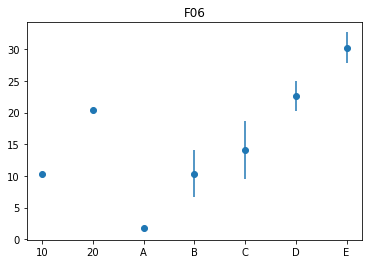

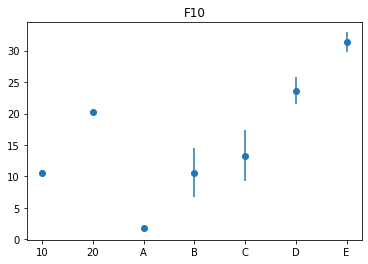

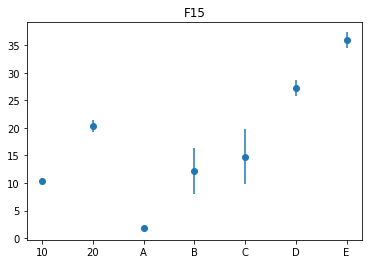

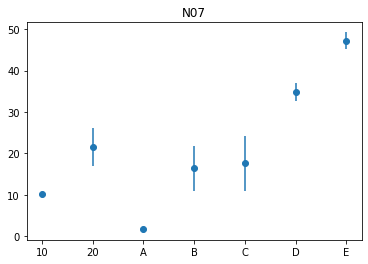

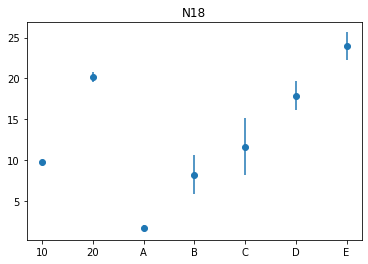

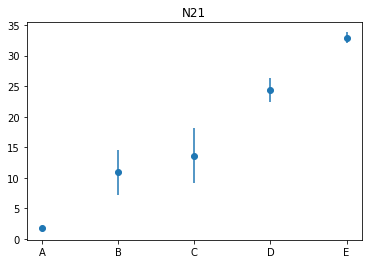

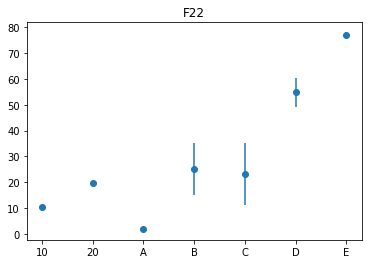

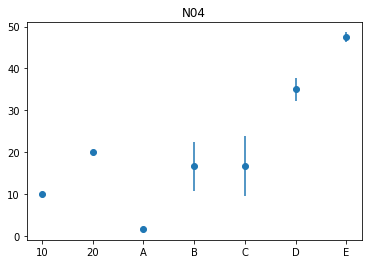

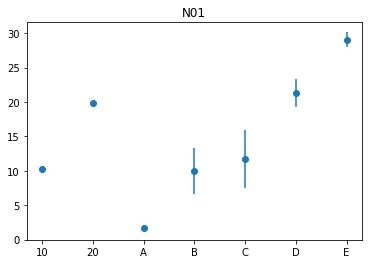

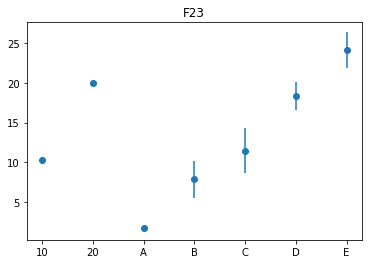

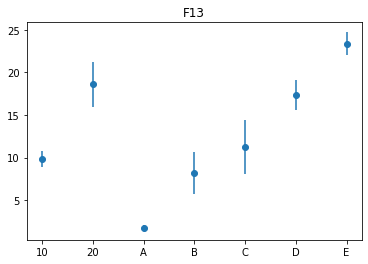

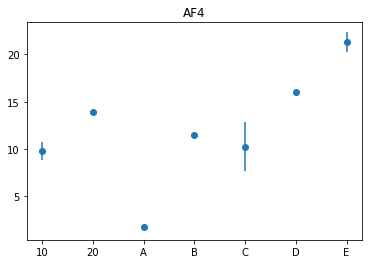

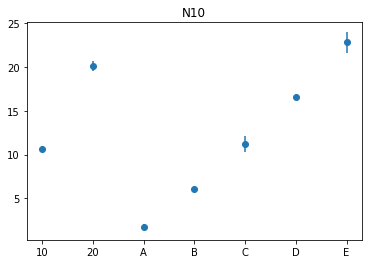

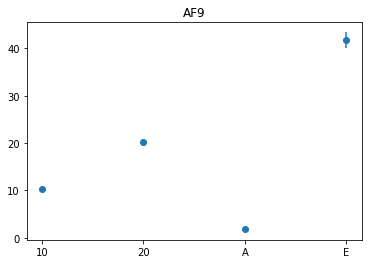

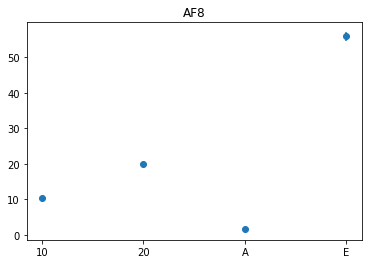

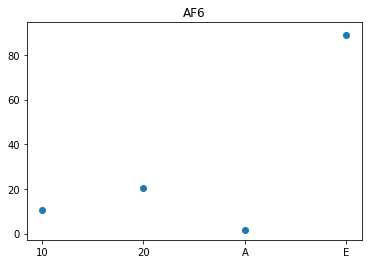

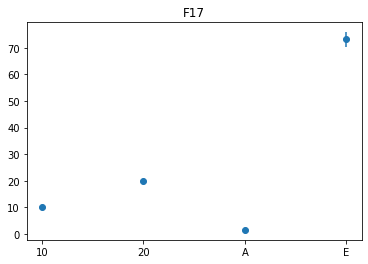

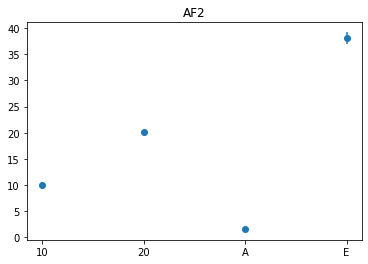

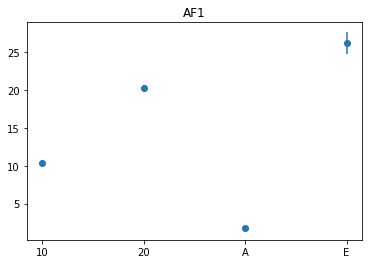

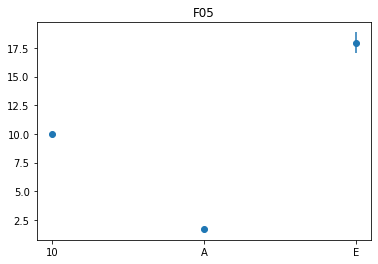

In [8]:
# Create a dictionary of the unique values in the STAT_ID column and a dataframe for all the rows with that value
stat_dict = {}
for stat in data_depth['STAT_ID'].unique():
    stat_dict[stat] = data_depth[data_depth['STAT_ID'] == stat]
    
# Each station in stat_dict, create a dictionary of the unique values in the SAMPLE_DEPTH_CODE and the mean value of the column DEPTH (m) for that code
stat_dict_depth = {}
for stat in stat_dict:
    stat_dict_depth[stat] = {}
    means = []
    stdevs = []
    summary_dict = {"DEPTH": [], "MEAN": [], "STDEV": []}
    for depth in stat_dict[stat]['SAMPLE_DEPTH_CODE'].unique():
        summary_dict["DEPTH"].append(depth)
        mean = stat_dict[stat][stat_dict[stat]['SAMPLE_DEPTH_CODE'] == depth]['DEPTH (m)'].mean()
        std = stat_dict[stat][stat_dict[stat]['SAMPLE_DEPTH_CODE'] == depth]['DEPTH (m)'].std()
        stat_dict_depth[stat][depth] = mean
        means.append(mean)
        stdevs.append(std)
        summary_dict["MEAN"].append(mean)
        summary_dict["STDEV"].append(std)
    
    # Sort the summary_dict by the depth column
    summary_dict = pd.DataFrame(summary_dict)
    summary_dict = summary_dict.sort_values('DEPTH')
  
    # Plot the list means on the y axis and use the list stdevs as vertical error bars
    plt.errorbar(summary_dict["DEPTH"], summary_dict["MEAN"], yerr=summary_dict["STDEV"], fmt='o')
    plt.title(stat)
    plt.show()

In [4]:
# For each row in the data where SAMPLE_DEPTH_CODE is not a letter or is nan,
# replace the SAMPLE_DEPTH_CODE the closest value in the dictionary of the mean depth for that station
for ind, row in data.iterrows():
  if row['SAMPLE_DEPTH_CODE'] not in ['A', 'B', 'C', 'D', 'E'] and type(row['SAMPLE_DEPTH_CODE']) != int:
    station = row['STAT_ID']
    depth = row['DEPTH (m)']
    if station in stat_dict_depth:
      closest_code = closest_code, closest_val = min(stat_dict_depth[station].items(), key=lambda x: abs(depth - x[1]))
      data.loc[ind, 'SAMPLE_DEPTH_CODE'] = closest_code

In [8]:
data.to_csv("../misc/resolved_stations.csv", index=False)